In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

unlabelled = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/dataset/final/subset_5_classes_2.csv")
unlabelled.emotion.value_counts()

Blueberry___healthy     1502
Tomato___Target_Spot    1404
Apple___Apple_scab      1000
Cherry___healthy        1000
Potato___Late_blight    1000
Name: emotion, dtype: int64

In [ ]:
import math
import warnings
import sklearn
import numpy as np
import pandas as pd
import random

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
warnings.filterwarnings('ignore')

# Data Loading & Processing

## Few-shot train data

In [ ]:
def load_labelled():
    global labelled
    labelled = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/dataset/final/subset_5_classes_2.csv")
    labelled = labelled.drop_duplicates(subset=['pixels'], keep='first')
    labelled.reset_index(inplace=True)
    labelled = labelled.drop(['index'], axis=1)
    print(f'Labelled sample Size : {labelled.shape[0]}')

In [ ]:
load_labelled()
for expression in list(labelled.emotion.unique()):
    print(f'{expression} : {labelled.emotion.value_counts()[expression]}')

Labelled sample Size : 5906
Apple___Apple_scab : 1000
Blueberry___healthy : 1502
Cherry___healthy : 1000
Potato___Late_blight : 1000
Tomato___Target_Spot : 1404


## Unlabelled data

In [ ]:
def load_unlabelled():
    global unlabelled
    unlabelled = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/dataset/final/subset_5_classes_2.csv")
    # classes = list(df.emotion.unique())
    # unlabelled = unlabelled[unlabelled['emotion'].isin(classes)]
    unlabelled = unlabelled.drop(['emotion'], axis=1)
    unlabelled = unlabelled.drop_duplicates(subset=['pixels'], keep='first')
    unlabelled.reset_index(inplace=True)
    unlabelled = unlabelled.drop(['index'], axis=1)
    print(f'Unlabelled sample size : {unlabelled.shape[0]}')

load_unlabelled()

Unlabelled sample size : 5906


# Helping Functions

## Data Selection and Processing

In [ ]:
def k_shot_selection(original_df, samples_per_class):
    df = pd.DataFrame(columns=['emotion', 'pixels'])
    grouped = original_df.groupby('emotion')

    for emotion, group_data in grouped:
        if len(group_data) >= samples_per_class:
            selected_samples = group_data.sample(n=samples_per_class, random_state=42)
        else:
            selected_samples = group_data.sample(n=len(group_data), random_state=42)

        df = df.append(selected_samples)

    df.reset_index(drop=True, inplace=True)
    df.emotion.value_counts()

    return df

In [ ]:
from keras.utils import to_categorical

def process_df(df):
    img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(84, 84, 3).astype('float32'))
    img_array = np.stack(img_array, axis=0)
    img_array = img_array / 255.

    le = LabelEncoder()
    img_labels = le.fit_transform(df.emotion)
    img_labels = to_categorical(img_labels)

    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
    return img_array, img_labels, le_name_mapping


def process_unlabelled_df(df):
    img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(84, 84, 3).astype('float32'))
    img_array = np.stack(img_array, axis=0)
    img_array = img_array / 255.

    return img_array

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

## Processing Pseudo labelled data

In [ ]:
import random
import math

def sample_size_selection(y_pred_pseudo, k_shot, multiplier=1):
    classes = ['Apple___Apple_scab', 'Blueberry___healthy', 'Cherry___healthy', 'Potato___Late_blight', 'Tomato___Target_Spot']
    counts = []
    for clss in classes:
        counts.append(y_pred_pseudo.count(clss))
    num_samples = min(min(counts), math.ceil(k_shot*multiplier))

    return num_samples

In [ ]:
def pseudo_label(model, k_shot, la_maps, multiplier=1, accuracy=0.99):
    arr = process_unlabelled_df(unlabelled)
    softmax = model.predict(arr)
    y_pred = np.argmax(softmax, axis=1)
    la_map_inverse = {x:y for y,x in la_maps.items()}

    probabilities = np.array([max(probability) for probability in softmax])
    max_probabilities = [probability for probability in probabilities if probability>=accuracy]
    prob_index = [index for index in range(len(probabilities)) if probabilities[index]>=accuracy]
    y_pred_pseudo = [y_pred[index] for index in prob_index] # label back to str
    y_pred_pseudo = [la_map_inverse[y_pred] for y_pred in y_pred_pseudo]

    num_samples = sample_size_selection(y_pred_pseudo, k_shot, multiplier)
    pseudo_df = unlabelled.iloc[prob_index]
    pseudo_df['emotion'] = y_pred_pseudo
    pseudo_df = k_shot_selection(pseudo_df, num_samples)

    cond = unlabelled['pixels'].isin(pseudo_df['pixels'])
    unlabelled.drop(unlabelled[cond].index, inplace=True)
    print(f'Unlabelled data size : {unlabelled.shape[0]}')

    print(f'Selected sample size : {num_samples}')

    return pseudo_df, num_samples

In [ ]:
def update_labelled(df):
    cond = labelled['pixels'].isin(df['pixels'])
    labelled.drop(labelled[cond].index, inplace=True)
    print(f'Labelled sample size : {labelled.shape[0]}')

In [ ]:
# _, _, la_maps = process_df(df)
# path = '/content/drive/MyDrive/Colab Notebooks/fewshot_learning/trained_models/fewshot_main_10.h5'
# model = keras.models.load_model(path)

In [ ]:
# load_unlabelled()
# temp, num_samples = pseudo_label(model, 10, la_maps, accuracy=0.995)

# Loading and Fine-tuning

In [ ]:
def test_model(k_shot, model, test_size, iter):
    k_shot_test = k_shot_selection(labelled, test_size)
    update_labelled(k_shot_test)
    test_arr, test_labels, _ = process_df(k_shot_test)
    test_arr, test_labels = sklearn.utils.shuffle(test_arr, test_labels)

    loss, accuracy = model.evaluate(test_arr, test_labels)

    y_pred = model.predict(test_arr)
    y_pred = np.argmax(y_pred, axis=1)
    test_labels = np.argmax(test_labels, axis=1)
    con_matrix = confusion_matrix(test_labels, y_pred)

    plt.figure(figsize=(5,4))
    ax = sns.heatmap(con_matrix, annot=True, cmap='Blues')
    title = str(k_shot) + '-shot\n\n'
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    # ax.xaxis.set_ticklabels(['Apple_Cedar', 'Grape_Esca', 'Strawberry_healthy', 'Tomato_Leaf_Curl', 'Tomato_Septoria'])
    # ax.yaxis.set_ticklabels(['Apple_Cedar', 'Grape_Esca', 'Strawberry_healthy', 'Tomato_Leaf_Curl', 'Tomato_Septoria'])
    fname = str(k_shot) + '.' + str(i+1)

    path = "/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/conf_mat/conf_matrix_" + fname + '.png'
    plt.savefig(path)

    return loss, accuracy

In [ ]:
def build_model(path):
    transfer_model = keras.models.load_model(path)

    for layer in transfer_model.layers[:-4]:
        layer.trainable = False

    # transfer_model.pop()
    # transfer_model.pop()
    # transfer_model.pop()
    # transfer_model.pop()

    x = transfer_model.layers[-5].output # flatten layer output

    x = keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1')(x)
    x = keras.layers.BatchNormalization(name='bathnorm_7')(x)
    x = keras.layers.Dropout(0.6, name='dropout_4')(x)

    predictions = keras.layers.Dense(len(labelled.emotion.unique()), activation='softmax', name='out_layer')(x)

    model = keras.models.Model(inputs=transfer_model.input, outputs=predictions)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
m = build_model("/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split2.h5")
m.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1_input (InputLayer  [(None, 84, 84, 3)]       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                           

In [ ]:
def call_back(filepath, monitor='loss', mode='min', patience=4):

    checkpoint = ModelCheckpoint(
        filepath,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        mode=mode
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor=monitor,
        factor=0.25,
        patience=patience,
        min_lr=1e-7,
        verbose=1
    )

    callbacks = [
        checkpoint,
        lr_scheduler
    ]

    return callbacks

In [ ]:
# a,d =

In [ ]:
k_shots = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
valid_size = 15
test_size = 15
epochs = 20

single_samples = {}
iterative_samples = {}

baseline_train_accuracy = {}
baseline_test_accuracy = {}
baseline_train_loss = {}
baseline_test_loss = {}

single_train_accuracy = {}
single_test_accuracy = {}
single_train_loss = {}
single_test_loss = {}

iterative_train_accuracy = {}
iterative_test_accuracy = {}
iterative_train_loss = {}
iterative_test_loss = {}

for k_shot in k_shots:
    single_samples[k_shot] = []
    iterative_samples[k_shot] = []

    baseline_train_accuracy[k_shot] = []
    baseline_test_accuracy[k_shot] = []
    baseline_train_loss[k_shot] = []
    baseline_test_loss[k_shot] = []

    single_train_accuracy[k_shot] = []
    single_test_accuracy[k_shot] = []
    single_train_loss[k_shot] = []
    single_test_loss[k_shot] = []

    iterative_train_accuracy[k_shot] = []
    iterative_test_accuracy[k_shot] = []
    iterative_train_loss[k_shot] = []
    iterative_test_loss[k_shot] = []


for k_shot in k_shots:
    for i in range(1):
        model_path = "/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split2.h5"

        # creating base model instance for few-shot learning
        new_model = build_model(model_path)
        load_labelled()

        kshot_df = k_shot_selection(labelled, k_shot)
        update_labelled(kshot_df)
        img_array, img_labels, la_maps = process_df(kshot_df)
        img_array, img_labels = sklearn.utils.shuffle(img_array, img_labels)

        k_shot_valid = k_shot_selection(labelled, valid_size)
        update_labelled(k_shot_valid)
        valid_arr, valid_labels, _ = process_df(k_shot_valid)
        valid_arr, valid_labels = sklearn.utils.shuffle(valid_arr, valid_labels)

        filepath = '/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/split_2/fewshot_main_' + str(k_shot) + '.' + str(i+1) + '.h5'
        callbacks = call_back(filepath)

        history = new_model.fit_generator(datagen.flow(img_array, img_labels, batch_size=k_shot), epochs=epochs, validation_data=(valid_arr, valid_labels), callbacks=callbacks)

        plt.figure(figsize=(10,4))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        title = 'Baseline ' + str(k_shot) + '-shot Accuracy'
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        path = '/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/baseline_acc_' + str(k_shot) + '_' + str(i+1) + '.png'
        plt.savefig(path)

        plt.figure(figsize=(10,4))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        title = 'Baseline ' + str(k_shot) + '-shot Loss'
        plt.title(title)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        path = '/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/baseline_loss_' + str(k_shot) + '_' + str(i+1) + '.png'
        plt.savefig(path)

        loss, accuracy = new_model.evaluate(img_array, img_labels)
        baseline_train_accuracy[k_shot].append(accuracy)
        baseline_train_loss[k_shot].append(loss)

        loss, accuracy = test_model(k_shot, new_model, test_size, i)
        baseline_test_accuracy[k_shot].append(accuracy)
        baseline_test_loss[k_shot].append(loss)


        del history
        del k_shot_valid
        del img_array, img_labels

        # Single Semi-Supervised
        load_unlabelled()
        single_ss_model = build_model(filepath)
        single_ss_df, single_ss_sample_size = pseudo_label(new_model, k_shot, la_maps, multiplier=0.3356, accuracy=0.995)
        single_ss_df = pd.concat([kshot_df, single_ss_df])

        del kshot_df

        single_samples[k_shot].append(single_ss_sample_size)

        filepath_single_ss = '/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/split_2/fewshot_single_' + str(k_shot) + '.' + str(i+1) + '.h5'
        callbacks = call_back(filepath_single_ss)

        single_img_arr, single_img_labels, la_maps = process_df(single_ss_df)
        single_img_arr, single_img_labels = sklearn.utils.shuffle(single_img_arr, single_img_labels)

        history = single_ss_model.fit_generator(datagen.flow(single_img_arr, single_img_labels), epochs=epochs, validation_data=(valid_arr, valid_labels), callbacks=callbacks)

        plt.figure(figsize=(10,4))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        title = 'Single SS ' + str(k_shot) + '-shot Accuracy'
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        path = '/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/single_ss_acc_' + str(k_shot) + '_' +  str(i+1) + '.png'
        plt.savefig(path)

        plt.figure(figsize=(10,4))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        title = 'Single SS ' + str(k_shot) + '-shot Loss'
        plt.title(title)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        path = '/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/single_ss_loss_' + str(k_shot) + '_' + str(i+1) + '.png'
        plt.savefig(path)

        loss, accuracy = single_ss_model.evaluate(single_img_arr, single_img_labels)
        single_train_accuracy[k_shot].append(accuracy)
        single_train_loss[k_shot].append(loss)

        loss, accuracy = test_model(k_shot, single_ss_model, test_size, i)
        single_test_accuracy[k_shot].append(accuracy)
        single_test_loss[k_shot].append(loss)

        del history
        del single_img_arr, single_img_labels


        # Iterative Semi-Supervised
        iterative_ss_model = build_model(filepath_single_ss)
        iterative_ss_df, iterative_ss_sample_size = pseudo_label(single_ss_model, k_shot, la_maps, multiplier=0.4612, accuracy=0.995)
        iterative_ss_df = pd.concat([iterative_ss_df, single_ss_df])

        del single_ss_df
        del single_ss_model

        iterative_samples[k_shot].append(iterative_ss_sample_size)

        filepath_iterative_ss = '/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/split_2/fewshot_iterative_' + str(k_shot) + '.' + str(i+1) + '.h5'
        callbacks = call_back(filepath_iterative_ss)

        iterative_img_arr, iterative_img_labels, la_maps = process_df(iterative_ss_df)
        iterative_img_arr, iterative_img_labels = sklearn.utils.shuffle(iterative_img_arr, iterative_img_labels)

        history = iterative_ss_model.fit_generator(datagen.flow(iterative_img_arr, iterative_img_labels), epochs=epochs, validation_data=(valid_arr, valid_labels), callbacks=callbacks)

        plt.figure(figsize=(10,4))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        title = 'Iterative SS ' + str(k_shot) + '-shot Accuracy'
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        path = '/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/iterative_ss_acc_' + str(k_shot) + '_' + str(i+1) + '.png'
        plt.savefig(path)

        plt.figure(figsize=(10,4))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        title = 'Iterative SS ' + str(k_shot) + '-shot Loss'
        plt.title(title)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        path = '/content/drive/MyDrive/Colab Notebooks/villagePlant/plots/split_2/iterative_ss_loss_' + str(k_shot) + '_' + str(i+1) + '.png'
        plt.savefig(path)

        loss, accuracy = iterative_ss_model.evaluate(iterative_img_arr, iterative_img_labels)
        iterative_train_accuracy[k_shot].append(accuracy)
        iterative_train_loss[k_shot].append(loss)

        loss, accuracy = test_model(k_shot, iterative_ss_model, test_size, i)
        iterative_test_accuracy[k_shot].append(accuracy)
        iterative_test_loss[k_shot].append(loss)

        del iterative_ss_model
        del history
        del iterative_img_arr, iterative_img_labels

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
base_train_acc = pd.DataFrame(baseline_train_accuracy)
base_train_acc.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_train_accuracy.csv")

base_train_loss = pd.DataFrame(baseline_train_loss)
base_train_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_train_loss.csv")

base_test_acc = pd.DataFrame(baseline_test_accuracy)
base_test_acc.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_test_accuracy.csv")

base_test_loss = pd.DataFrame(baseline_test_loss)
base_test_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_test_loss.csv")

single_train_acc = pd.DataFrame(single_train_accuracy)
single_train_acc.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_train_accuracy.csv")

singl_train_loss = pd.DataFrame(single_train_loss)
singl_train_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_train_loss.csv")

singl_test_acc = pd.DataFrame(single_test_accuracy)
singl_test_acc.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_test_accuracy.csv")

singl_test_loss = pd.DataFrame(single_test_loss)
singl_test_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_test_loss.csv")

iterative_train_acc = pd.DataFrame(iterative_train_accuracy)
iterative_train_acc.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_train_accuracy.csv")

iter_train_loss = pd.DataFrame(iterative_train_loss)
iter_train_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_train_loss.csv")

iter_test_acc = pd.DataFrame(iterative_test_accuracy)
iter_test_acc.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_test_loss.csv")

iter_test_loss = pd.DataFrame(iterative_test_loss)
iter_test_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_test_accuracy.csv")

single_ss_samples = pd.DataFrame(single_samples)
single_ss_samples.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_samples.csv")

iterative_ss_samples = pd.DataFrame(iterative_samples)
iterative_ss_samples.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_samples.csv")


In [ ]:
train_accuracy = {}
test_accuracy = {}
train_loss = {}
test_loss = {}

samples = {}

for k_shot in k_shots:
    train_accuracy[k_shot] = []
    test_accuracy[k_shot] = []
    train_loss[k_shot] = []
    test_loss[k_shot] = []
    samples[k_shot] = []


base_train_acc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_train_accuracy.csv")
base_train_loss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_train_loss.csv")
base_test_acc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_test_accuracy.csv")
base_test_loss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_test_loss.csv")

singl_train_acc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_train_accuracy.csv")
singl_train_loss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_train_loss.csv")
singl_test_acc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_test_accuracy.csv")
singl_test_loss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_test_loss.csv")

iter_train_acc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_train_accuracy.csv")
iter_train_loss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_train_loss.csv")
iter_test_acc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/baseline_test_loss.csv")
iter_test_loss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_test_accuracy.csv")

single_ss_samples = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/single_samples.csv")
iterative_ss_samples = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/iterative_samples.csv")

for k_shot in k_shots:
    train_accuracy[k_shot].append(np.mean(base_train_acc[str(k_shot)]))
    train_accuracy[k_shot].append(np.mean(singl_train_acc[str(k_shot)]))
    train_accuracy[k_shot].append(np.mean(iter_train_acc[str(k_shot)]))

    test_accuracy[k_shot].append(np.mean(base_test_acc[str(k_shot)]))
    test_accuracy[k_shot].append(np.mean(singl_test_acc[str(k_shot)]))
    test_accuracy[k_shot].append(np.mean(iter_test_acc[str(k_shot)]))

    train_loss[k_shot].append(np.mean(base_train_loss[str(k_shot)]))
    train_loss[k_shot].append(np.mean(singl_train_loss[str(k_shot)]))
    train_loss[k_shot].append(np.mean(iter_train_loss[str(k_shot)]))

    test_loss[k_shot].append(np.mean(base_test_loss[str(k_shot)]))
    test_loss[k_shot].append(np.mean(singl_test_loss[str(k_shot)]))
    test_loss[k_shot].append(np.mean(iter_test_loss[str(k_shot)]))

    samples[k_shot].append(k_shot*3)
    samples[k_shot].append(single_ss_samples[str(k_shot)][0]*3)
    samples[k_shot].append(iterative_ss_samples[str(k_shot)][0]*3)

train_accuracy = pd.DataFrame(train_accuracy)
test_accuracy = pd.DataFrame(test_accuracy)
train_loss = pd.DataFrame(train_loss)
test_loss = pd.DataFrame(test_loss)
samples = pd.DataFrame(samples)

train_accuracy.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/train_accuracy.csv")
test_accuracy.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/test_accuracy.csv")
train_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/train_loss.csv")
test_loss.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/test_loss.csv")

samples.to_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/results/split_2/samples.csv")

In [ ]:
train_accuracy.head()

,1,5,10,20,30,40,50,60,70,80,90,100
0,0.2,1.0,1.000000,1.0,0.993333,0.995000,0.980000,0.973333,0.991429,0.985000,0.986667,0.990000
1,1.0,1.0,1.000000,1.0,1.000000,0.992593,1.000000,0.992593,0.993617,0.998131,0.998347,0.992537
2,1.0,1.0,0.989474,1.0,0.992727,0.991781,0.993407,0.994495,0.998425,0.994444,0.993865,0.990055


In [ ]:
train_loss.head()

,1,5,10,20,30,40,50,60,70,80,90,100
0,2.558816e+00,0.001053,0.005100,0.016498,0.018976,0.017671,0.037179,0.045122,0.029227,0.032730,0.032991,0.035886
1,3.576278e-08,0.000256,0.001686,0.003350,0.009387,0.019007,0.009266,0.022409,0.019825,0.017580,0.008396,0.023625
2,9.982403e-04,0.000176,0.030175,0.005037,0.013705,0.016005,0.016207,0.017131,0.007756,0.016162,0.018896,0.025133


In [ ]:
test_accuracy.head()

,1,5,10,20,30,40,50,60,70,80,90,100
0,0.226667,0.866667,0.933333,0.920000,0.893333,0.960000,0.880000,0.933333,0.973333,0.933333,0.960000,0.986667
1,0.586667,0.813333,0.880000,0.946667,0.920000,0.960000,0.986667,0.946667,0.946667,0.986667,0.960000,0.973333
2,0.720000,0.920000,0.893333,0.933333,0.960000,0.933333,0.973333,0.960000,0.973333,0.946667,0.986667,0.973333


In [ ]:
test_loss.head()

,1,5,10,20,30,40,50,60,70,80,90,100
0,0.720000,0.920000,0.893333,0.933333,0.960000,0.933333,0.973333,0.960000,0.973333,0.946667,0.986667,0.973333
1,4.745712,1.493204,0.528358,0.142976,0.183857,0.048446,0.053797,0.202981,0.255506,0.033446,0.249739,0.038158
2,2.985095,0.464178,0.474137,0.257333,0.275185,0.184678,0.052108,0.247855,0.071486,0.106680,0.044384,0.042040


In [ ]:
samples.head()

,1,5,10,20,30,40,50,60,70,80,90,100
0,3,15,30,60,90,120,150,180,210,240,270,300
1,3,6,12,21,33,42,51,63,72,81,93,102
2,3,9,15,30,42,57,72,84,99,111,126,141


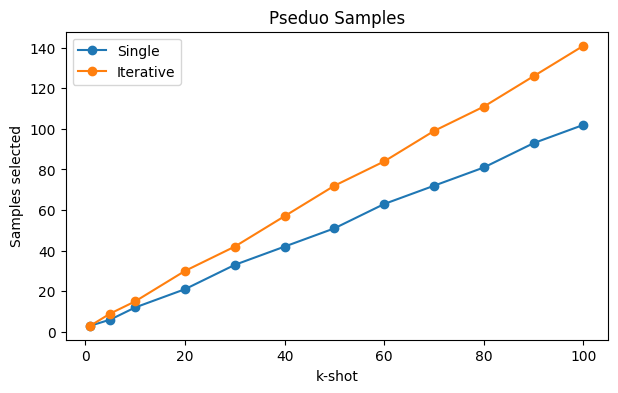

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(k_shots, samples.loc[1], marker="o")
plt.plot(k_shots, samples.loc[2], marker="o")
plt.legend(['Single', 'Iterative'], loc='best')
plt.title('Pseduo Samples')
plt.xlabel('k-shot')
plt.ylabel('Samples selected')
plt.show()